## Predicting a simple sine curve using an LSTM

In [1]:
import os
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

plt.rcParams["figure.figsize"] = (35,5)

ROOT = "/content/drive/My Drive/"

In [0]:
## gen sine wave for fun 

In [2]:
np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [5]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []


        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)


        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]


        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs
def closure():
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss

In [4]:
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')


In [6]:
data.shape ## 100 rows of length 1000  ( height, width )

(100, 1000)

In [7]:
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

In [128]:
print(input.size(), target.size())  ## 97 rows of size 999


torch.Size([97, 999]) torch.Size([97, 999])


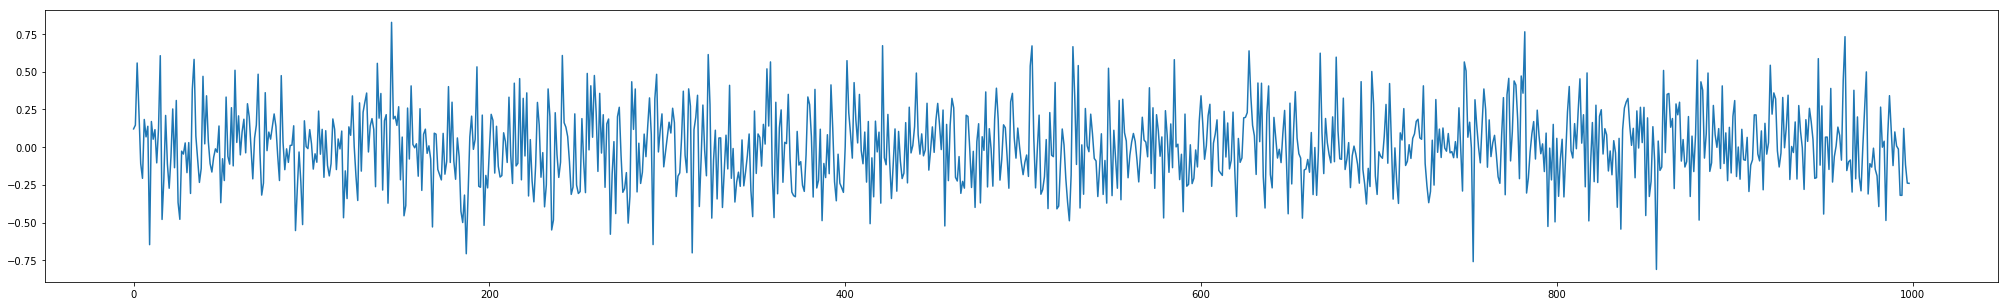

In [9]:
plt.rcParams["figure.figsize"] = (35,5)
noise = torch.Tensor(np.random.randn(97,999)/4).double()
plt.plot(noise[0])
plt.show()

In [10]:
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
seq

Sequence(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)

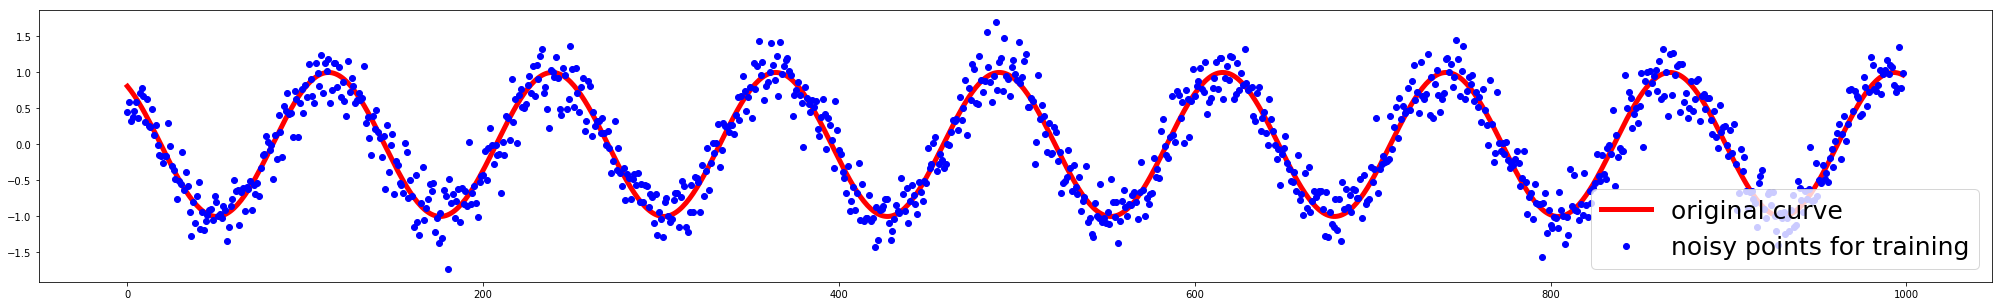

In [11]:
plt.rcParams["figure.figsize"] = (35,5)

plt.plot(input[10], "r", label = "original curve", linewidth = 5)

input += noise
plt.plot(input[10], "bo", label = "noisy points for training")
plt.legend(fontsize = 25)
plt.show()

In [12]:
criterion = nn.MSELoss()
output = seq(input)
print("initial loss = ", criterion(output, target).item())

initial loss =  0.5650597809553963


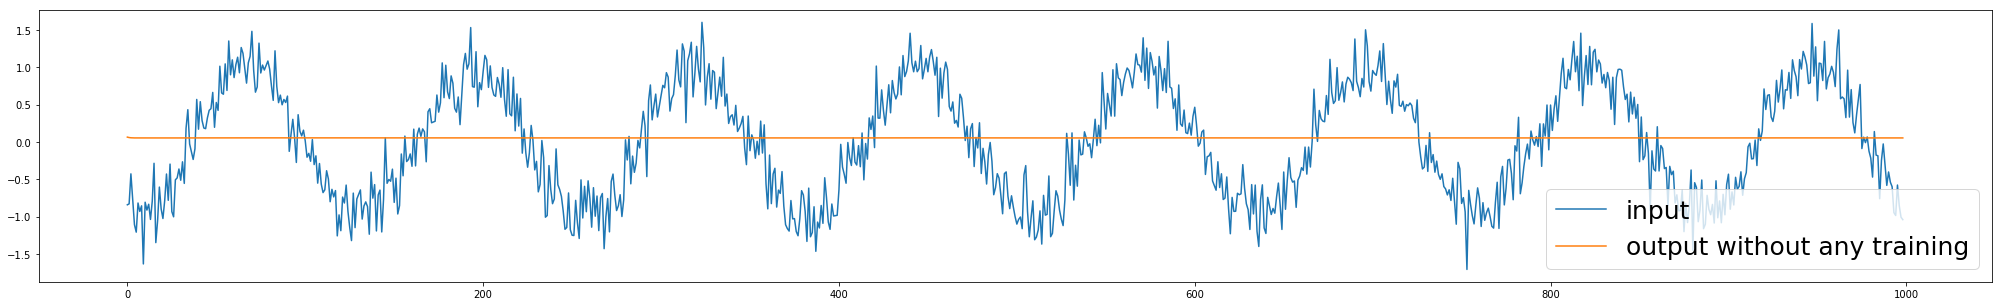

In [13]:
plt.plot(input[0],  label = "input")
plt.plot(output[0].detach(), label = "output without any training")
plt.legend(fontsize = 25)
plt.show()

In [14]:
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

In [ ]:
def closure():
    optimizer.zero_grad()
    out = seq(input)
    loss = criterion(out, target)
    print('loss:', loss.item())
    loss.backward()
    return loss
optimizer.step(closure)

loss after one optimizer step =  0.0811


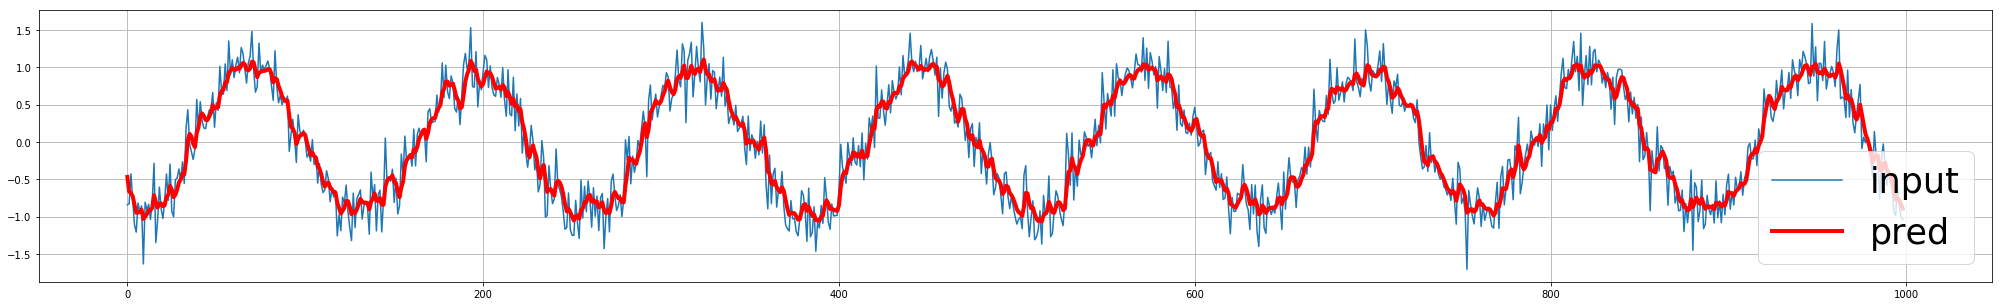

In [16]:
output = seq(input)
print("loss after one optimizer step = ", round(criterion(output, target).item(), 4))
plt.plot(input[0], label = "input")
plt.plot(output[0].detach(), "r", label = "pred", linewidth = 4)
plt.legend(fontsize = 35)
plt.grid()
plt.show()